In [2]:
import ee
import geemap 
from landsatxplore.api import API

In [2]:
ee.Authenticate()


Successfully saved authorization token.


In [4]:
ee.Initialize()

In [7]:
Map = geemap.Map()


In [5]:
#image = ee.Image('LANDSAT/LE7_TOA_5YEAR/1999_2003')
dataset_landsat = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2').filterDate('2023-09-01', '2023-10-01')
def apply_scale_factors(image):
  optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
  return image.addBands(optical_bands, None, True).addBands(
      thermal_bands, None, True
  )
dataset_landsat= dataset_landsat.map(apply_scale_factors)
landsat_vis = {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0.0,'max': 0.3}
landsat_vis_new_red = {'bands': ['SR_B4'], 'gamma': 1.4,'min': 0.0,'max': 0.3}
landsat_vis_new_nir = {'bands': ['SR_B5'], 'gamma': 1.4,'min': 0.0,'max': 0.3}

#Map.addLayer(image, landsat_vis, "LE7_TOA_5YEAR/1999_2003", True, 0.7)
Map.addLayer(dataset_landsat, landsat_vis,  'True Color (432)')
Map.set_center(15.38615,54.08763,16)
Map

Map(center=[54.08763, 15.38615], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

In [45]:
def mask_s2_clouds(image):
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)


dataset_sentinel =ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterDate('2023-09-15', '2023-11-30').filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)).map(mask_s2_clouds)


visualization_sentinel = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}

Map.add_layer(dataset_sentinel.mean(), visualization_sentinel, 'RGB')
Map.set_center(15.38615,54.08763,16)
Map

Map(center=[54.08763, 15.38615], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

In [210]:
#Map

In [38]:
# Draw any shapes on the map using the Drawing tools before executing this code block
feature = Map.draw_last_feature

if feature is None:
    geom = ee.Geometry.Polygon(
        [
            [
                [15.38615,54.08763],#[15.38,54.08],
                [15.38615,54.09047],#[15.38,54.09],
                [15.39200,54.09047],#[15.39,54.09],
                [15.39200,54.08763],#[15.39,54.08],
                [15.38615,54.08763],#[15.38,54.08],
            ]
        ]
    )
    feature = ee.Feature(geom, {})

roi = feature.geometry()

In [46]:
#image=dataset_sentinel.mean()
image=dataset_sentinel.median()
#image = dataset_landsat.median()

#image_10m = image.resample('bilinear').reproject(crs=image.projection(), scale=500)
image_new = image.clip(roi).unmask()
geemap.ee_export_image(
    image_new, filename='./mapa_sentinel/mapa_new_sentinel.tif', scale=1, region=roi, file_per_band=True
)

Generating URL ...
Please wait ...
Data downloaded to c:\Users\pawel\Pulpit\Projekty\Sentinel\mapa_sentinel


In [40]:
#image = ee.Image('COPERNICUS/S2_SR_HARMONIZED')
Map = geemap.Map(zoom=16)

Map.set_center(15.386136194516476,54.08756365231493)
#Map.add_layer(geom,{'color': 'blue'})


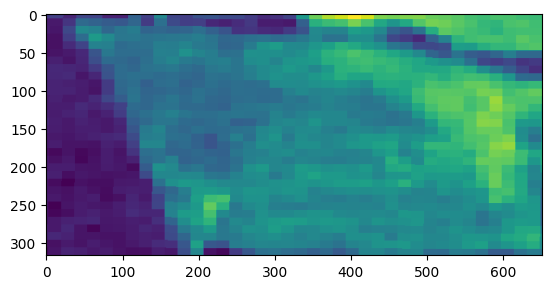

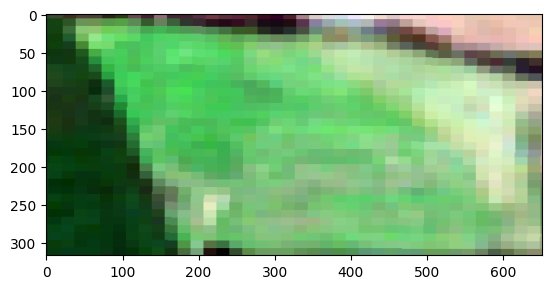

In [44]:
import rasterio
from rasterio.plot import show
import numpy as np  
import matplotlib.pyplot as plt

raster = rasterio.open('./mapa_sentinel/mapa_new_sentinel.tif')

def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

nir = raster.read(4)
red = raster.read(3)
green = raster.read(2)

# Normalize band DN
nir_norm = normalize(nir)
red_norm = normalize(red)
green_norm = normalize(green)


# Stack bands
nrg = np.dstack((nir_norm, red_norm, green_norm))

show(green_norm)
plt.imshow(nrg)

<Axes: >

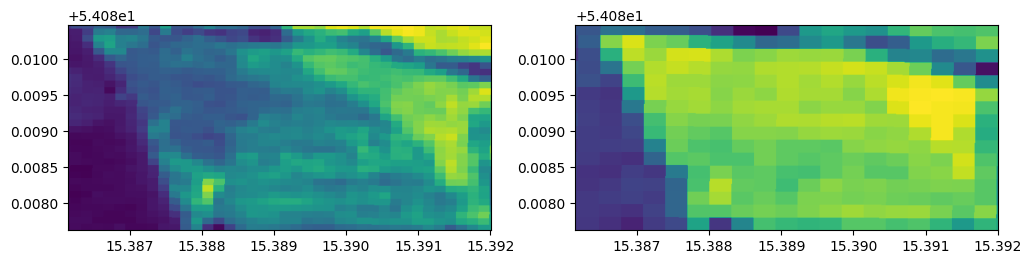

In [48]:
# NDVI calculate 

band_red = rasterio.open('./mapa_sentinel/mapa_new_sentinel.B4.tif')
band_nir  = rasterio.open('./mapa_sentinel/mapa_new_sentinel.B5.tif')

print(band_nir.crs) 
#show(band_red)

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(12,6))
show(band_red,ax=ax1)
show(band_nir,ax=ax2)

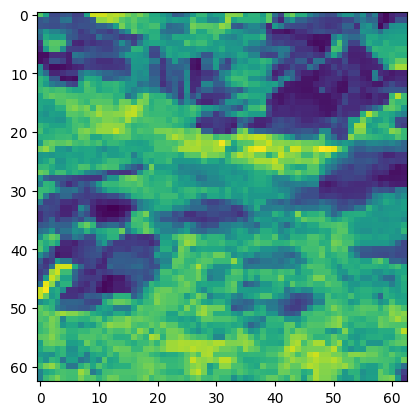

<Axes: >

In [17]:
red = band_red.read(1).astype('float64')
nir = band_nir.read(1).astype('float64')

ndvi = np.where( 
    (nir+red)==0.,
    0,
    (nir-red)/(nir+red)
)

show(ndvi) 